In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

Nx = 101
Ny = 101

c = 1
dx = 1
dy = 1
dt = min(dx, dy) / np.sqrt(2) / c

x = np.arange(Nx)
y = np.arange(Ny)
X, Y = np.meshgrid(x, y)

source_x = int(Nx / 2)
source_y = int(Ny / 2)

E_z = np.zeros([Nx, Ny])
H_x = np.zeros([Nx, Ny - 1])
H_y = np.zeros([Nx - 1, Ny])

E_t = []

E_z_n = E_z.copy()
E_z_n_1 = E_z_n.copy()
H_x_n = H_x.copy()
H_x_n_1 = H_x_n.copy()
H_y_n = H_x.copy()
H_y_n_1 = H_y_n.copy()

print("E_z.shape: {}, H_x.shape: {}, H_y.shape: {}".format(E_z.shape, H_x.shape, H_y.shape))
print(np.shape(E_z[:, 1:] - E_z[:, :-1]))
print(np.shape(E_z[1:, :] - E_z[:-1, :]))

E_z.shape: (101, 101), H_x.shape: (101, 100), H_y.shape: (100, 101)
(101, 100)
(100, 101)


In [2]:
n_iter = 150

for n in range(n_iter):
    # Update magnetic fields at time step n+1/2
    H_x = H_x - dt / dx * (E_z[:, 1:] - E_z[:, :-1])
    H_y = H_y + dt / dx * (E_z[1:, :] - E_z[:-1, :])
    
    # Update electric field at time step n+1
    diff_H_x = dt / dx * (H_x[1:-1, 1:] - H_x[1:-1, :-1])
    diff_H_y = dt / dx * (H_y[1:, 1:-1] - H_y[:-1, 1:-1])
    E_z[1:-1, 1:-1] = E_z[1:-1, 1:-1] + (diff_H_y - diff_H_x)
    
    # Pulse at time step n+1
    pulse = (np.pi * ((1 / np.sqrt(2) * n) / 20 - 1))**2
    pulse = (1 - 2 * pulse) * np.exp(-pulse)
    E_z[source_x, source_y] = E_z[source_x, source_y] + pulse
    
    # ABC for top boundary
    temp1 = np.sqrt(dt / dx * dt / dx)
    temp2 = 1 / temp1 + 2 + temp1
    coef0 = -(1 / temp1 - 2 + temp1) / temp2
    coef1 = -2 * (temp1 - 1 / temp1) / temp2
    coef2 = 4 * (temp1 + 1 / temp1) / temp2
    E_z[0, :] = coef0 * (E_z[2, :] + E_z_n_1[0, :]) + \
                coef1 * (E_z_n[0, :] + E_z_n[2, :] - E_z[1, :] - E_z_n_1[1, :]) + \
                coef2 * E_z_n[1, :] - E_z_n_1[2, :]
    
    # ABC for bottom boundary
    E_z[-1, :] = coef0 * (E_z[-3, :] + E_z_n_1[-1, :]) + \
                coef1 * (E_z_n[-1, :] + E_z_n[-3, :] - E_z[-2, :] - E_z_n_1[-2, :]) + \
                coef2 * E_z_n[-2, :] - E_z_n_1[-3, :]
    
    # ABC for left boundary
    E_z[:, 0] = coef0 * (E_z[:, 2] + E_z_n_1[:, 0]) + \
                coef1 * (E_z_n[:, 0] + E_z_n[:, 2] - E_z[:, 1] - E_z_n_1[:, 1]) + \
                coef2 * E_z_n[:, 1] - E_z_n_1[:, 2]
    
    # ABC for right boundary
    E_z[:, -1] = coef0 * (E_z[:, -3] + E_z_n_1[:, -1]) + \
                coef1 * (E_z_n[:, -1] + E_z_n[:, -3] - E_z[:, -2] - E_z_n_1[:, -2]) + \
                coef2 * E_z_n[:, -2] - E_z_n_1[:, -3]
    
    # Store magnetic and electric fields for ABC at time step n
    H_x_n_1 = H_x_n.copy() # data for t = n-1
    H_x_n = H_x.copy()     # data for t = n

    H_y_n_1 = H_y_n.copy() # data for t = n-1
    H_y_n = H_y.copy()     # data for t = n
    
    E_z_n_1 = E_z_n.copy() # data for t = n-1
    E_z_n = E_z.copy()     # data for t = n
    
    #E_t.append(E_z[source_x, source_y])
    E_t.append(E_z.copy())

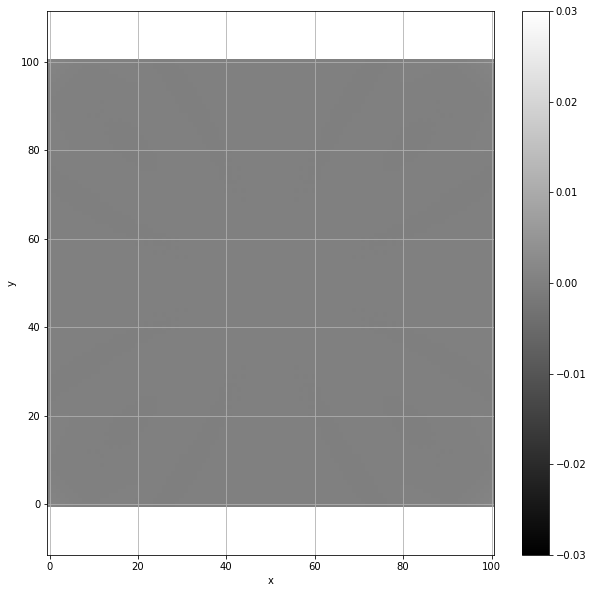

In [3]:
plt.figure(figsize = (10, 10))
plt.pcolormesh(x, y, E_z, shading = "auto", cmap = "gray")
plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis("equal")
plt.colorbar()
plt.clim(-0.03, 0.03)
plt.show()

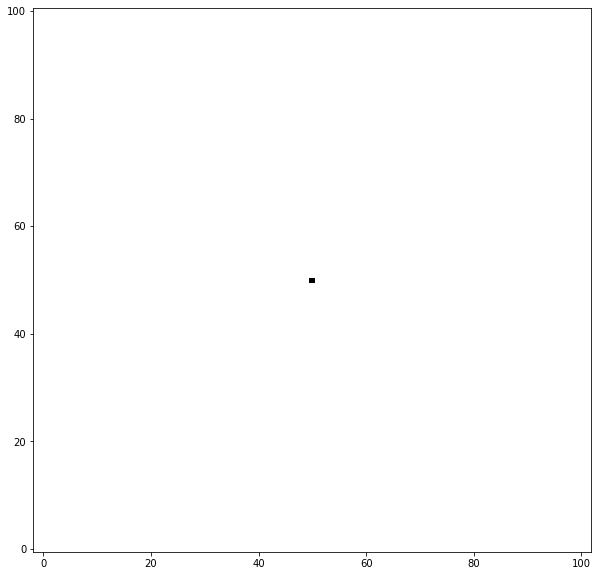

In [4]:
if False:
    fig, ax = plt.subplots(figsize = (10, 10))
    cax = ax.pcolormesh(x, y, E_t[0], shading = "auto", cmap = "gray")
    plt.axis("equal")

    def animate(i):
         cax.set_array(E_t[i].flatten())

    anim = FuncAnimation(fig, animate, interval = 50, frames = len(E_t) - 1)

    plt.show()

    anim.save("fdtd_animation.gif", writer = "pillow")